# S05 – Инженерный ML-эксперимент с линейными моделями (sklearn)

В этом ноутбуке мы делаем **минимальный, но честный ML-эксперимент**:

1. Берём табличный датасет (из `sklearn.datasets`).
2. Делим его на три части: **train / validation / test**.
3. Строим **бейзлайн-модель** (DummyClassifier), чтобы понимать нижнюю планку качества.
4. Строим **логистическую регрессию** в виде `Pipeline`:
   - препроцессинг (масштабирование признаков),
   - сама модель.
5. Считаем метрики качества: accuracy, precision, recall, f1, ROC-AUC.
6. Строим **ROC-кривую** и **PR-кривую**.
7. Показываем, как можно **калибровать вероятности** (Brier score до/после).

Цель: получить шаблон эксперимента, который можно потом адаптировать под свой датасет в проекте/ДЗ.


## Импорты и общие настройки

Здесь мы подключаем всё, что понадобится:

- `numpy`, `pandas` – базовые библиотеки для работы с табличными данными;
- из `sklearn`:
  - `datasets` – встроенные учебные датасеты;
  - `model_selection` – разбиение данных и GridSearch;
  - `pipeline`, `preprocessing` – `Pipeline` и масштабирование признаков;
  - классификаторы (`DummyClassifier`, `LogisticRegression`);
  - метрики;
  - инструменты для ROC/PR-кривых;
  - инструменты для калибровки вероятностей.

Также фиксируем `RANDOM_STATE`, чтобы результаты можно было воспроизвести.

In [ ]:
# Базовые библиотеки
import numpy as np
import pandas as pd

# Воспроизводимость
RANDOM_STATE = 42

# Библиотеки sklearn для данных, моделей, разбиения и метрик
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    brier_score_loss,
)

# Для калибровки
from sklearn.calibration import CalibratedClassifierCV

## Загрузка датасета и первичный взгляд

Чтобы не отвлекаться на чистку/парсинг, используем встроенный датасет
`breast_cancer` из `sklearn.datasets`:

- это **бинарная классификация**;
- все признаки **числовые**, а значит легко подключить `StandardScaler`;
- размер небольшой, что весьма удобно для семинара.

Здесь мы:

1. загружаем данные в `pandas.DataFrame`;
2. смотрим форму таблицы и первые несколько строк;
3. смотрим распределение классов – есть ли сильный дисбаланс.

In [ ]:
# Загружаем встроенный датасет "рак груди" (бинарная классификация)
# as_frame=True даст нам pandas DataFrame, что удобно для EDA
data = load_breast_cancer(as_frame=True)

X = data.data        # признаки (таблица)
y = data.target      # таргет (0/1)

# Сохраним названия классов (0 -> malignant / 1 -> benign и т.п.)
target_names = data.target_names

print("Форма X:", X.shape)
print("Форма y:", y.shape)
print("Названия признаков:", list(X.columns)[:5], "...")  # первые 5
print("Названия классов:", target_names)

# Быстрый взгляд на данные
display(X.head())

# Распределение классов
y.value_counts(normalize=True).rename("fraction").to_frame()

Форма X: (569, 30)
Форма y: (569,)
Названия признаков: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness'] ...
Названия классов: ['malignant' 'benign']


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,fraction
target,
1,0.627417
0,0.372583


## Разбиение на train / validation / test

Очень важно **не обучать и не оценивать модель на одних и тех же данных**.

Мы используем схему:

1. Сначала делим данные на:
   - `X_temp, y_temp` – 80% (train и validation),
   - `X_test, y_test` – 20% (честная финальная проверка).
2. Затем из `X_temp, y_temp` ещё выделяем:
   - `X_train, y_train` – 60% от исходных данных,
   - `X_val, y_val` – 20% от исходных данных.

Параметры:

- `test_size=...` – доля данных в test/val;
- `stratify=y` – сохраняем долю классов (особенно важно при дисбалансе);
- `random_state=RANDOM_STATE` – фиксируем случайность.

In [ ]:
# 1. Отделяем тестовую выборку (например, 20% данных)
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,          # важно для классификации: сохраняем долю классов
    random_state=RANDOM_STATE,
)

# 2. Делим оставшиеся данные на train и validation (например, 60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,      # 0.25 от X_temp = 0.25 * 0.8 = 0.2 от исходных
    stratify=y_temp,
    random_state=RANDOM_STATE,
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  val:  ", X_val.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (val):")
print(y_val.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (341, 30)
  val:   (114, 30)
  test:  (114, 30)

Распределение классов (train):
target
1    0.627566
0    0.372434
Name: proportion, dtype: float64

Распределение классов (val):
target
1    0.622807
0    0.377193
Name: proportion, dtype: float64

Распределение классов (test):
target
1    0.631579
0    0.368421
Name: proportion, dtype: float64


## Бейзлайн-модель: DummyClassifier

Прежде чем строить «умную» модель, полезно понять, как будет вести себя **очень простая**:

- `DummyClassifier(strategy="most_frequent")` всегда предсказывает **самый частый класс** из train.
- Такой подход почти не использует информацию из признаков, но даёт **нижнюю планку качества**:
  > любая нормальная модель должна быть лучше бейзлайна.  

Здесь мы:

1. обучаем бейзлайн на `X_train, y_train`;
2. считаем метрики на `X_val, y_val`.

### Набор метрик, на которые мы смотрим

Кратко напомним, что мы считаем:

- `accuracy` – доля правильных ответов;
- `precision` – из всех предсказанных «положительных» объектов сколько действительно положительные;
- `recall` – из всех **реально** положительных сколько модель поймала;
- `f1` – компромисс между precision и recall;
- `ROC-AUC` – площадь под ROC-кривой, показывает, насколько хорошо модель ранжирует объекты.

В задачах с возможным дисбалансом классов (как здесь) **нельзя смотреть только на accuracy**, важно учитывать хотя бы F1 и ROC-AUC.

In [ ]:
# Бейзлайн-модель: ничего "умного", просто предсказываем самый частый класс (или случайно)
baseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

# Обучаем только на train
baseline.fit(X_train, y_train)

# Оцениваем на validation
y_val_pred_baseline = baseline.predict(X_val)
y_val_proba_baseline = baseline.predict_proba(X_val)[:, 1]

print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_baseline))
print("Precision:", precision_score(y_val, y_val_pred_baseline, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_baseline, zero_division=0))

# Для ROC-AUC нам нужны вероятности положительного класса
try:
    print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_baseline))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, most_frequent) – качество на validation ===
Accuracy : 0.6228070175438597
Precision: 0.6228070175438597
Recall   : 1.0
F1-score : 0.7675675675675676
ROC-AUC  : 0.5


## Логистическая регрессия в виде Pipeline

Теперь берём первую «нормальную» модель – **логистическую регрессию**.

Проблема: признаки могут быть в разных масштабах.  
Поэтому мы соберём `Pipeline`, который делает два шага подряд:

1. `StandardScaler()` – масштабирует признаки (вычитает среднее, делит на std).
2. `LogisticRegression(...)` – обучает линейный классификатор на этих масштабированных признаках.

Важно:

- `Pipeline` – это **одна большая модель** с методами `fit`, `predict`, `predict_proba`.
- Мы обучаем и применяем **один и тот же** пайплайн – меньше шансов ошибиться.

In [ ]:
# Собираем Pipeline:
# 1) Масштабирование признаков (StandardScaler)
# 2) Логистическая регрессия
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=1.0,              # сила регуляризации (чем меньше C, тем сильнее регуляризация)
                solver="liblinear", # надёжный солвер для маленьких датасетов
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# Обучаем pipeline на train
log_reg_pipeline.fit(X_train, y_train)

# Предсказываем на validation
y_val_pred = log_reg_pipeline.predict(X_val)
y_val_proba = log_reg_pipeline.predict_proba(X_val)[:, 1]

print("=== Логистическая регрессия (C=1.0) – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba))

print("\nПодробный отчёт по классам (classification_report):")
print(classification_report(y_val, y_val_pred, target_names=target_names))

=== Логистическая регрессия (C=1.0) – качество на validation ===
Accuracy : 0.9824561403508771
Precision: 0.9859154929577465
Recall   : 0.9859154929577465
F1-score : 0.9859154929577465
ROC-AUC  : 0.9980347199475925

Подробный отчёт по классам (classification_report):
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        43
      benign       0.99      0.99      0.99        71

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## Подбор гиперпараметра C (регуляризация) через GridSearchCV

У логистической регрессии есть важный параметр `C`:

- **чем меньше C**, тем **сильнее регуляризация** (модель проще, меньше переобучается);
- **чем больше C**, тем модель свободнее (может переобучиться).

Вместо ручного перебора мы используем `GridSearchCV`:

- задаём сетку значений `C`;
- внутри `GridSearchCV`:
  - для каждого варианта `C` запускается кросс-валидация;
  - по выбранной метрике (`scoring="roc_auc"`) выбирается лучший вариант.

Обратите внимание:

- в названии параметра используется `имя_шага__имя_параметра`: `logreg__C`.

In [ ]:
# Настроим сетку по параметру C (сила регуляризации)
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

# GridSearchCV будет:
# - внутри делать кросс-валидацию по train
# - выбирать лучший C по заданной метрике (например, ROC-AUC).
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",    # можно поменять на f1, recall и т.д.
    cv=5,
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 0.1}
Лучший ROC-AUC (по CV): 0.9925639321918391


## Оценка лучшей модели: validation и test

После `GridSearchCV` у нас есть:

- `grid_search.best_estimator_` – пайплайн с лучшим `C`.

Дальше:

1. Смотрим метрики на **validation** (для обсуждения и сравнения с предыдущей моделью).
2. Смотрим метрики на **test** – это финальная, честная оценка.

In [ ]:
# Берём лучшую найденную модель
best_model = grid_search.best_estimator_

# Оцениваем на validation
y_val_pred_best = best_model.predict(X_val)
y_val_proba_best = best_model.predict_proba(X_val)[:, 1]

print("=== Лучшая модель – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_best))
print("Precision:", precision_score(y_val, y_val_pred_best, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_best, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_best, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_best))

# Оцениваем на test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Лучшая модель – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

=== Лучшая модель – качество на validation ===
Accuracy : 0.9736842105263158
Precision: 0.9594594594594594
Recall   : 1.0
F1-score : 0.9793103448275862
ROC-AUC  : 0.9970520799213888

=== Лучшая модель – качество на test ===
Accuracy : 0.9824561403508771
Precision: 0.9861111111111112
Recall   : 0.9861111111111112
F1-score : 0.9861111111111112
ROC-AUC  : 0.996031746031746

Classification report (test):
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## ROC-кривая

ROC-кривая показывает, как меняется качество модели при разных порогах отсечения:

- по оси X – False Positive Rate (ложные срабатывания),
- по оси Y – True Positive Rate (чувствительность / полнота).

Здесь используем готовый helper из `sklearn.metrics`: `RocCurveDisplay.from_predictions`.

Обратите внимание: для нашего учебного датасета кривая получается почти «квадратной», а AUC близок к 1.0.  
В реальной жизни это редкость и часто повод проверить:
- нет ли утечки данных (в фичах уже зашит таргет),
- не слишком ли простая задача по сравнению с бизнес-реальностью.

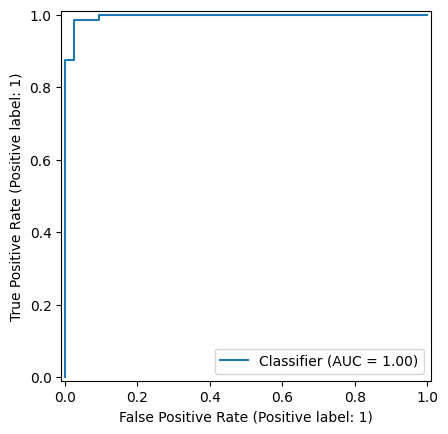

In [ ]:
RocCurveDisplay.from_predictions(
    y_test,
    y_test_proba,
)

## PR-кривая (Precision-Recall)

PR-кривая особенно полезна при дисбалансе классов:

- по оси X – recall (полнота),
- по оси Y – precision (точность).

Снова используем helper из sklearn.

Здесь PR-кривая тоже почти идеальная. Это хороший повод подчеркнуть, что встроенные датасеты sklearn часто намного проще реальных данных, и в боевых задачах PR/ROC будут выглядеть гораздо скромнее.

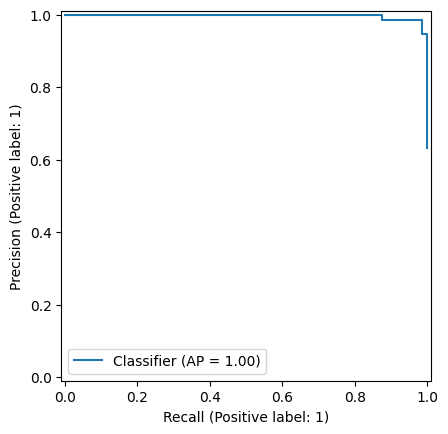

In [ ]:
PrecisionRecallDisplay.from_predictions(
    y_test,
    y_test_proba,
)

## Пример калибровки вероятностей

Иногда нам важны не только «классы», но **честные вероятности**:

- если модель говорит `0.8`, это должно означать, что примерно в 80% случаев объект действительно относится к классу 1;
- это важнее, чем просто «кто больше 0.5 → класс 1».

`CalibratedClassifierCV` позволяет улучшить калибровку вероятностей:

1. Берём базовый классификатор (наш Pipeline).
2. Оборачиваем его в `CalibratedClassifierCV(estimator=..., method="sigmoid")`.
3. Сравниваем **Brier score** до и после (чем меньше, тем лучше калибровка).

Здесь показываем идею на validation.

In [ ]:
# 1. Базовый (некалиброванный) классификатор: pipeline из StandardScaler + LogisticRegression
base_clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                penalty="l2",
                C=0.1,              # пусть будет довольно сильная регуляризация
                solver="liblinear",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# Обучаем базовую модель на train, чтобы оценить качество ДО калибровки
base_clf.fit(X_train, y_train)

y_val_proba_base = base_clf.predict_proba(X_val)[:, 1]
brier_before = brier_score_loss(y_val, y_val_proba_base)
print("Brier score до калибровки:", brier_before)

# 2. Оборачиваем тот же самый pipeline в CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(
    estimator=base_clf,
    method="sigmoid",   # Platt scaling (логистическая регрессия сверху)
    cv=5,
)

# Калибровку обучаем на тех же train-данных (внутри будет CV-разбиение)
calibrated_clf.fit(X_train, y_train)

# Смотрим Brier score после калибровки на validation
y_val_proba_cal = calibrated_clf.predict_proba(X_val)[:, 1]
brier_after = brier_score_loss(y_val, y_val_proba_cal)
print("Brier score после калибровки:", brier_after)

Brier score до калибровки: 0.025946143775613918
Brier score после калибровки: 0.031902282812673044


В идеале `brier_after < brier_before`, но не всегда, поэтому необходимо помнить, что:
* калибровка – это не про «улучшить ROC/accuracy», а все-таки про честные вероятности;
* иногда модель и до калибровки достаточно хорошо калибрована.

Для логистической регрессии калибровка обычно мало что меняет – она и так неплохо калибрована.  
Гораздо заметнее эффект бывает у деревьев и ансамблей (`RandomForest`, `GradientBoosting` и т.п.).

## Выводы

В этом ноутбуке мы сделали минимальный, но честный ML-эксперимент:

1. **Разбили данные** на train / validation / test и работали с ними по ролям.
2. Построили **бейзлайн-модель** и увидели, что нормальная модель должна быть лучше.
3. Собрали `Pipeline` с `StandardScaler` и `LogisticRegression`, обучили, посчитали метрики.
4. Через `GridSearchCV` подобрали параметр регуляризации `C`.
5. Оценили лучшую модель на **test** и построили ROC/PR-кривые.
6. Показали, как `CalibratedClassifierCV` может улучшить **калибровку вероятностей**.

Дальше в курсе:

- вы можете взять этот шаблон, заменить:
  - блок загрузки данных (свой `read_csv`),
  - список признаков/таргет,
  - сетку гиперпараметров,
- и использовать тот же подход для других моделей (`RandomForest`, `GradientBoosting`, и т.д.).

## Бонус 1: линеаризация через расширение признаков (PolynomialFeatures b LogisticRegression)

На лекции мелькала идея **линеаризации**:  
иногда данные в исходном пространстве признаков плохо разделимы “прямой”,  
но если перейти в **другое пространство признаков** φ(x), то там линейная модель уже работает хорошо.

Здесь мы показываем эту идею на игрушечном примере `make_moons`:

- данные в 2D, классы переплетены – одной прямой их разделить сложно;
- сначала обучаем **обычную логистическую регрессию** на исходных признаках (линейная граница);
- потом добавляем шаг `PolynomialFeatures(degree=3)`:
  - создаём новые признаки вида x₁², x₁x₂, x₂², x₁³, …;
  - модель остаётся **линейной по этим новым признакам**, но в исходном пространстве граница становится “кривой”.

На картинках:

- **слева** – логрег на исходных признаках (граница почти прямая, задачка плохо решается);
- **справа** – логрег после линеаризации (poly-фичи), граница огибает “лунки” намного лучше.

Это как раз иллюстрация того, что:

- «нелинейная» модель в исходных координатах = **линейная модель в другом пространстве признаков**;
- дальнейшие темы (ядровой SVM, нейросети, эмбеддинги) по сути развивают эту же идею:  
  *сначала построить хорошее представление фич, а потом применить к ним простую модель наверху*.

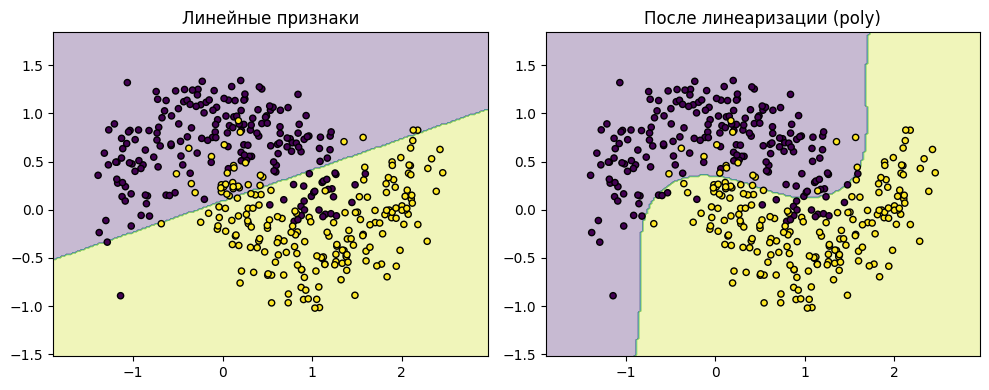

In [ ]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

X_moons, y_moons = make_moons(n_samples=400, noise=0.25, random_state=RANDOM_STATE)

# Модель 1: просто логистическая регрессия
clf_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=RANDOM_STATE)),
])
clf_linear.fit(X_moons, y_moons)

# Модель 2: полиномиальные признаки + логистическая регрессия
clf_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
])
clf_poly.fit(X_moons, y_moons)

def plot_decision_boundary(model, X, y, ax, title: str):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
    ax.set_title(title)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_decision_boundary(clf_linear, X_moons, y_moons, axes[0], "Линейные признаки")
plot_decision_boundary(clf_poly, X_moons, y_moons, axes[1], "После линеаризации (poly)")
plt.tight_layout()


## Бонус 2: SVM и ядровой трюк

На лекции говорили про **SVM** и идею того, что можно:
- искать гиперплоскость с максимальной маржей (линейный SVM),
- а можно использовать **ядра**, которые неявно переносят данные в другое пространство (ядровой трюк).

Здесь мы на том же датасете `make_moons` сравним два варианта:

1. `LinearSVC` – линейный SVM (граница – прямая в исходном пространстве).
2. `SVC(kernel="rbf")` – SVM с RBF-ядром (граница может быть “кривой”).

Это как раз иллюстрирует связку:
- *линеаризация* / ядровой трюк → линейная модель в другом пространстве признаков,
- SVM как один из способов реализовать это.

LinearSVC accuracy: 0.8425
RBF SVC accuracy: 0.9175


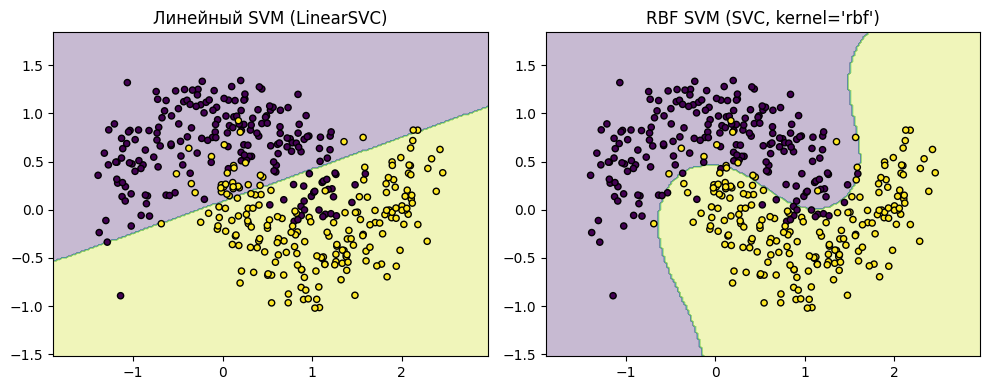

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score

RANDOM_STATE = 42

# Генерируем "лунки" – нелинейно разделимую задачу
X_moons, y_moons = make_moons(
    n_samples=400,
    noise=0.25,
    random_state=RANDOM_STATE,
)

def plot_decision_boundary(model, X, y, ax, title: str):
    """Вспомогательная функция: рисуем decision boundary модели."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200),
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(grid).reshape(xx.shape)

    ax.contourf(xx, yy, zz, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
    ax.set_title(title)

# 1) Линейный SVM: гиперплоскость в исходном пространстве
linear_svm = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "svm",
            LinearSVC(
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

linear_svm.fit(X_moons, y_moons)
y_pred_linear = linear_svm.predict(X_moons)
print("LinearSVC accuracy:", accuracy_score(y_moons, y_pred_linear))

# 2) SVM с RBF-ядром: ядровой трюк, нелинейная граница
rbf_svm = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "svm",
            SVC(
                kernel="rbf",
                C=1.0,
                gamma="scale",
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

rbf_svm.fit(X_moons, y_moons)
y_pred_rbf = rbf_svm.predict(X_moons)
print("RBF SVC accuracy:", accuracy_score(y_moons, y_pred_rbf))

# Рисуем две границы принятия решения на одном рисунке
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plot_decision_boundary(linear_svm, X_moons, y_moons, axes[0], "Линейный SVM (LinearSVC)")
plot_decision_boundary(rbf_svm, X_moons, y_moons, axes[1], "RBF SVM (SVC, kernel='rbf')")

plt.tight_layout()
